C:\Users\raman\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Audio data shape: (661794,)
Sampling Rate: 22050


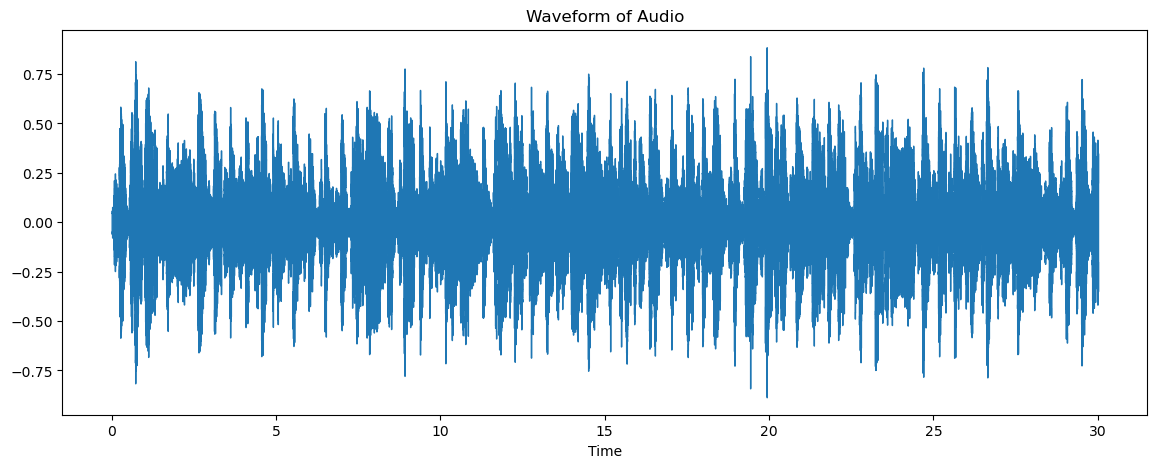

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Path to an example audio file
audio_path = "genres/blues/blues.00000.au"   # Fixed to .au

# Load the audio file
y, sr = librosa.load(audio_path)

# Print details
print("Audio data shape:", y.shape)
print("Sampling Rate:", sr)

# Plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Audio")
plt.show()


MFCC shape (coefficients x time frames): (40, 1293)


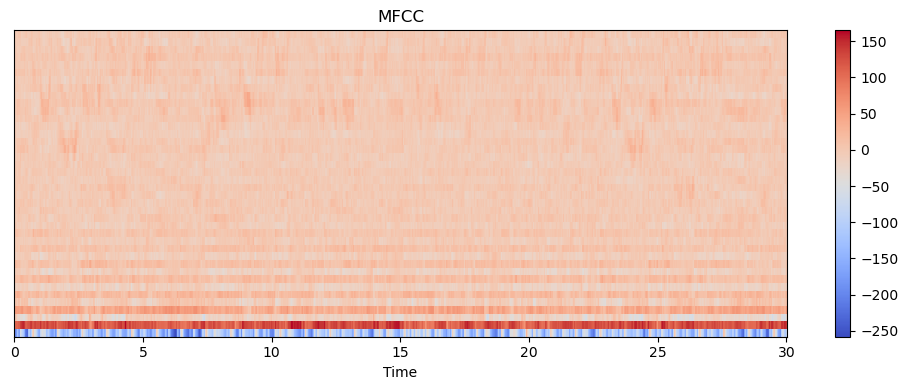

In [2]:
import numpy as np

# Load audio file (same as before)
audio_path = "genres/blues/blues.00000.au"
y, sr = librosa.load(audio_path)

# Extract MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

print("MFCC shape (coefficients x time frames):", mfcc.shape)

# Visualize MFCCs
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [3]:
import os
import numpy as np
import librosa

data = []
labels = []
genres = []

# Collect genre names
for genre in os.listdir("genres"):
    genres.append(genre)

print("Genres:", genres)

# Loop through all genres and files
for genre in genres:
    genre_path = os.path.join("genres", genre)
    
    for filename in os.listdir(genre_path):
        if filename.endswith(".au"):
            file_path = os.path.join(genre_path, filename)

            # Load audio
            y, sr = librosa.load(file_path)

            # Extract MFCC
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

            # Take mean of MFCC across time to make fixed length feature
            mfcc_mean = np.mean(mfcc, axis=1)

            data.append(mfcc_mean)
            labels.append(genre)

print("Finished processing all files.")
print("Total samples:", len(data))


Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Finished processing all files.
Total samples: 1000


In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert list to numpy array
X = np.array(data)
y = np.array(labels)

print("X shape (features):", X.shape)
print("y shape (labels):", y.shape)

# Encode labels to numbers (blues → 0, classical → 1, etc.)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Encoded labels:", y_encoded[:10])


X shape (features): (1000, 40)
y shape (labels): (1000,)
Encoded labels: [0 0 0 0 0 0 0 0 0 0]


In [5]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 800
Validation samples: 200


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # number of genres
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop])


Epoch 1/50


C:\Users\raman\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1953 - loss: 10.6339 - val_accuracy: 0.3600 - val_loss: 3.4415
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4191 - loss: 2.5724 - val_accuracy: 0.3700 - val_loss: 2.2531
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4624 - loss: 1.8114 - val_accuracy: 0.3600 - val_loss: 2.2317
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5587 - loss: 1.4634 - val_accuracy: 0.4200 - val_loss: 1.7675
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6381 - loss: 1.1517 - val_accuracy: 0.4800 - val_loss: 1.7359
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6611 - loss: 1.0377 - val_accuracy: 0.4850 - val_loss: 1.6854
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6416 - loss: 1.0710 - val_accuracy: 0.4400 - val_loss: 1.6024
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6760 - loss: 0.9607 - val_accuracy: 0.5400 - val_loss: 1.4525
E

In [7]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation Accuracy:", val_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5897 - loss: 1.3452 
Validation Accuracy: 0.5600000023841858


In [8]:
model.save("music_genre_model.h5")
print("Saved!")


Saved!


In [9]:
model.save("music_genre_model.keras")
print("Saved!")


Saved!


In [10]:
from keras.models import load_model

model = load_model("music_genre_model.keras")
print("Model loaded successfully!")


Model loaded successfully!


C:\Users\raman\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Extract MFCC (same config as used in training)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Take mean across time axis → make it shape (40,)
mfcc = np.mean(mfcc.T, axis=0)

# Reshape to match model input
mfcc = mfcc.reshape(1, 40)

# Predict
prediction = model.predict(mfcc)

# Get predicted class
predicted_class = np.argmax(prediction)
print("Predicted Genre Class:", predicted_class)

# Map to genre
genre_map = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 
             5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

print("Predicted Genre:", genre_map[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Genre Class: 0
Predicted Genre: blues
